[![下载Notebook](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/r2.4.0/resource/_static/logo_notebook.svg)](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/notebook/r2.4.0/tutorials/zh_cn/cv/mindspore_shufflenet.ipynb)&emsp;[![下载样例代码](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/r2.4.0/resource/_static/logo_download_code.svg)](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/notebook/r2.4.0/tutorials/zh_cn/cv/mindspore_shufflenet.py)&emsp;[![查看源文件](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/r2.4.0/resource/_static/logo_source.svg)](https://gitee.com/mindspore/docs/blob/r2.4.0/tutorials/source_zh_cn/cv/shufflenet.ipynb)

# ShuffleNet图像分类

> 当前案例不支持在GPU设备上静态图模式运行，其他模式运行皆支持。

## ShuffleNet网络介绍

ShuffleNetV1是旷视科技提出的一种计算高效的CNN模型，和MobileNet, SqueezeNet等一样主要应用在移动端，所以模型的设计目标就是利用有限的计算资源来达到最好的模型精度。ShuffleNetV1的设计核心是引入了两种操作：Pointwise Group Convolution和Channel Shuffle，这在保持精度的同时大大降低了模型的计算量。因此，ShuffleNetV1和MobileNet类似，都是通过设计更高效的网络结构来实现模型的压缩和加速。

> 了解ShuffleNet更多详细内容，详见论文[ShuffleNet](https://arxiv.org/abs/1707.01083)。

如下图所示，ShuffleNet在保持不低的准确率的前提下，将参数量几乎降低到了最小，因此其运算速度较快，单位参数量对模型准确率的贡献非常高。

![shufflenet1](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/r2.4.0/tutorials/source_zh_cn/cv/images/shufflenet_1.png)

> 图片来源：Bianco S, Cadene R, Celona L, et al. Benchmark analysis of representative deep neural network architectures[J]. IEEE access, 2018, 6: 64270-64277.

## 模型架构

ShuffleNet最显著的特点在于对不同通道进行重排来解决Group Convolution带来的弊端。通过对ResNet的Bottleneck单元进行改进，在较小的计算量的情况下达到了较高的准确率。

### Pointwise Group Convolution

Group Convolution（分组卷积）原理如下图所示，相比于普通的卷积操作，分组卷积的情况下，每一组的卷积核大小为in_channels/g\*k\*k，一共有g组，所有组共有(in_channels/g\*k\*k)\*out_channels个参数，是正常卷积参数的1/g。分组卷积中，每个卷积核只处理输入特征图的一部分通道，**其优点在于参数量会有所降低，但输出通道数仍等于卷积核的数量**。

![shufflenet2](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/r2.4.0/tutorials/source_zh_cn/cv/images/shufflenet_2.png)

> 图片来源：Huang G, Liu S, Van der Maaten L, et al. Condensenet: An efficient densenet using learned group convolutions[C]//Proceedings of the IEEE conference on computer vision and pattern recognition. 2018: 2752-2761.

Depthwise Convolution（深度可分离卷积）将组数g分为和输入通道相等的`in_channels`，然后对每一个`in_channels`做卷积操作，每个卷积核只处理一个通道，记卷积核大小为1\*k\*k，则卷积核参数量为：in_channels\*k\*k，**得到的feature maps通道数与输入通道数相等**；

Pointwise Group Convolution（逐点分组卷积）在分组卷积的基础上，令**每一组的卷积核大小为** $1\times 1$，卷积核参数量为(in_channels/g\*1\*1)\*out_channels。

In [1]:
!pip install mindspore==2.3.1

Looking in indexes: http://mirrors.aliyun.com/pypi/simple
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 328.8/328.8 MB 913.4 kB/s eta 0:00:0000:0100:08


In [2]:
!pip install mindnlp==0.3.1

Looking in indexes: http://mirrors.aliyun.com/pypi/simple
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.7/5.7 MB 1.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.8/316.8 kB 1.7 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 2.0 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 459.5/459.5 kB 2.0 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 1.8 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 2.0 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.2/19.2 MB 1.7 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 1.9 MB/s eta 0:00:0000:0100:010m
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 782.5/782.5 kB 1.3 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━

In [3]:
from mindspore import nn
import mindspore.ops as ops
from mindspore import Tensor

class GroupConv(nn.Cell):
    def __init__(self, in_channels, out_channels, kernel_size,
                 stride, pad_mode="pad", pad=0, groups=1, has_bias=False):
        super(GroupConv, self).__init__()
        self.groups = groups
        self.convs = nn.CellList()
        for _ in range(groups):
            self.convs.append(nn.Conv2d(in_channels // groups, out_channels // groups,
                                        kernel_size=kernel_size, stride=stride, has_bias=has_bias,
                                        padding=pad, pad_mode=pad_mode, group=1, weight_init='xavier_uniform'))

    def construct(self, x):
        features = ops.split(x, split_size_or_sections=int(len(x[0]) // self.groups), axis=1)
        outputs = ()
        for i in range(self.groups):
            outputs = outputs + (self.convs[i](features[i].astype("float32")),)
        out = ops.cat(outputs, axis=1)
        return out

[WARNING] ME(1397:281473339277344,MainProcess):2025-05-12-17:43:58.496.000 [mindspore/run_check/_check_version.py:357] MindSpore version 2.3.1 and Ascend AI software package (Ascend Data Center Solution)version 7.6 does not match, the version of software package expect one of ['7.2', '7.3']. Please refer to the match info on: https://www.mindspore.cn/install
/root/miniconda3/lib/python3.10/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/root/miniconda3/lib/python3.10/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/root/miniconda3/lib/python3.10/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar

### Channel Shuffle

Group Convolution的弊端在于不同组别的通道无法进行信息交流，堆积GConv层后一个问题是不同组之间的特征图是不通信的，这就好像分成了g个互不相干的道路，每一个人各走各的，**这可能会降低网络的特征提取能力**。这也是Xception，MobileNet等网络采用密集的1x1卷积（Dense Pointwise Convolution）的原因。

为了解决不同组别通道“近亲繁殖”的问题，ShuffleNet优化了大量密集的1x1卷积（在使用的情况下计算量占用率达到了惊人的93.4%），引入Channel Shuffle机制（通道重排）。这项操作直观上表现为将不同分组通道**均匀分散重组**，使网络在下一层能处理不同组别通道的信息。

![shufflenet3](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/r2.4.0/tutorials/source_zh_cn/cv/images/shufflenet_3.png)

如下图所示，对于g组，每组有n个通道的特征图，首先reshape成g行n列的矩阵，再将矩阵转置成n行g列，最后进行flatten操作，得到新的排列。这些操作都是可微分可导的且计算简单，在解决了信息交互的同时符合了ShuffleNet轻量级网络设计的轻量特征。

![shufflenet4](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/r2.4.0/tutorials/source_zh_cn/cv/images/shufflenet_4.png)

为了阅读方便，将Channel Shuffle的代码实现放在下方ShuffleNet模块的代码中。

### ShuffleNet模块

如下图所示，ShuffleNet对ResNet中的Bottleneck结构进行由(a)到(b), (c)的更改：

1. 将开始和最后的$1\times 1$卷积模块（降维、升维）改成Point Wise Group Convolution；

2. 为了进行不同通道的信息交流，再降维之后进行Channel Shuffle；

3. 降采样模块中，$3 \times 3$ Depth Wise Convolution的步长设置为2，长宽降为原来的一半，因此shortcut中采用步长为2的$3\times 3$平均池化，并把相加改成拼接。

![shufflenet5](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/r2.4.0/tutorials/source_zh_cn/cv/images/shufflenet_5.png)

In [4]:
class ShuffleV1Block(nn.Cell):
    def __init__(self, inp, oup, group, first_group, mid_channels, ksize, stride):
        super(ShuffleV1Block, self).__init__()
        self.stride = stride
        pad = ksize // 2
        self.group = group
        if stride == 2:
            outputs = oup - inp
        else:
            outputs = oup
        self.relu = nn.ReLU()
        branch_main_1 = [
            GroupConv(in_channels=inp, out_channels=mid_channels,
                      kernel_size=1, stride=1, pad_mode="pad", pad=0,
                      groups=1 if first_group else group),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(),
        ]
        branch_main_2 = [
            nn.Conv2d(mid_channels, mid_channels, kernel_size=ksize, stride=stride,
                      pad_mode='pad', padding=pad, group=mid_channels,
                      weight_init='xavier_uniform', has_bias=False),
            nn.BatchNorm2d(mid_channels),
            GroupConv(in_channels=mid_channels, out_channels=outputs,
                      kernel_size=1, stride=1, pad_mode="pad", pad=0,
                      groups=group),
            nn.BatchNorm2d(outputs),
        ]
        self.branch_main_1 = nn.SequentialCell(branch_main_1)
        self.branch_main_2 = nn.SequentialCell(branch_main_2)
        if stride == 2:
            self.branch_proj = nn.AvgPool2d(kernel_size=3, stride=2, pad_mode='same')

    def construct(self, old_x):
        left = old_x
        right = old_x
        out = old_x
        right = self.branch_main_1(right)
        if self.group > 1:
            right = self.channel_shuffle(right)
        right = self.branch_main_2(right)
        if self.stride == 1:
            out = self.relu(left + right)
        elif self.stride == 2:
            left = self.branch_proj(left)
            out = ops.cat((left, right), 1)
            out = self.relu(out)
        return out

    def channel_shuffle(self, x):
        batchsize, num_channels, height, width = ops.shape(x)
        group_channels = num_channels // self.group
        x = ops.reshape(x, (batchsize, group_channels, self.group, height, width))
        x = ops.transpose(x, (0, 2, 1, 3, 4))
        x = ops.reshape(x, (batchsize, num_channels, height, width))
        return x

### 构建ShuffleNet网络

ShuffleNet网络结构如下图所示，以输入图像$224 \times 224$，组数3（g = 3）为例，首先通过数量24，卷积核大小为$3 \times 3$，stride为2的卷积层，输出特征图大小为$112 \times 112$，channel为24；然后通过stride为2的最大池化层，输出特征图大小为$56 \times 56$，channel数不变；再堆叠3个ShuffleNet模块（Stage2, Stage3, Stage4），三个模块分别重复4次、8次、4次，其中每个模块开始先经过一次下采样模块（上图(c)），使特征图长宽减半，channel翻倍（Stage2的下采样模块除外，将channel数从24变为240）；随后经过全局平均池化，输出大小为$1 \times 1 \times 960$，再经过全连接层和softmax，得到分类概率。

![shufflenet6](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/r2.4.0/tutorials/source_zh_cn/cv/images/shufflenet_6.png)

In [5]:
class ShuffleNetV1(nn.Cell):
    def __init__(self, n_class=1000, model_size='2.0x', group=3):
        super(ShuffleNetV1, self).__init__()
        print('model size is ', model_size)
        self.stage_repeats = [4, 8, 4]
        self.model_size = model_size
        if group == 3:
            if model_size == '0.5x':
                self.stage_out_channels = [-1, 12, 120, 240, 480]
            elif model_size == '1.0x':
                self.stage_out_channels = [-1, 24, 240, 480, 960]
            elif model_size == '1.5x':
                self.stage_out_channels = [-1, 24, 360, 720, 1440]
            elif model_size == '2.0x':
                self.stage_out_channels = [-1, 48, 480, 960, 1920]
            else:
                raise NotImplementedError
        elif group == 8:
            if model_size == '0.5x':
                self.stage_out_channels = [-1, 16, 192, 384, 768]
            elif model_size == '1.0x':
                self.stage_out_channels = [-1, 24, 384, 768, 1536]
            elif model_size == '1.5x':
                self.stage_out_channels = [-1, 24, 576, 1152, 2304]
            elif model_size == '2.0x':
                self.stage_out_channels = [-1, 48, 768, 1536, 3072]
            else:
                raise NotImplementedError
        input_channel = self.stage_out_channels[1]
        self.first_conv = nn.SequentialCell(
            nn.Conv2d(3, input_channel, 3, 2, 'pad', 1, weight_init='xavier_uniform', has_bias=False),
            nn.BatchNorm2d(input_channel),
            nn.ReLU(),
        )
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, pad_mode='same')
        features = []
        for idxstage in range(len(self.stage_repeats)):
            numrepeat = self.stage_repeats[idxstage]
            output_channel = self.stage_out_channels[idxstage + 2]
            for i in range(numrepeat):
                stride = 2 if i == 0 else 1
                first_group = idxstage == 0 and i == 0
                features.append(ShuffleV1Block(input_channel, output_channel,
                                               group=group, first_group=first_group,
                                               mid_channels=output_channel // 4, ksize=3, stride=stride))
                input_channel = output_channel
        self.features = nn.SequentialCell(features)
        self.globalpool = nn.AvgPool2d(7)
        self.classifier = nn.Dense(self.stage_out_channels[-1], n_class)

    def construct(self, x):
        x = self.first_conv(x)
        x = self.maxpool(x)
        x = self.features(x)
        x = self.globalpool(x)
        x = ops.reshape(x, (-1, self.stage_out_channels[-1]))
        x = self.classifier(x)
        return x

## 模型训练和评估

采用CIFAR-10数据集对ShuffleNet进行预训练。

### 训练集准备与加载

采用CIFAR-10数据集对ShuffleNet进行预训练。CIFAR-10共有60000张32*32的彩色图像，均匀地分为10个类别，其中50000张图片作为训练集，10000图片作为测试集。如下示例使用`mindspore.dataset.Cifar10Dataset`接口下载并加载CIFAR-10的训练集。目前仅支持二进制版本（CIFAR-10 binary version）。

In [7]:
!pip install download

Looking in indexes: http://mirrors.aliyun.com/pypi/simple


In [8]:
from download import download

url = "https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/notebook/datasets/cifar-10-binary.tar.gz"

download(url, "./dataset", kind="tar.gz", replace=True)

Creating data folder...

file_sizes: 100%|████████████████████████████| 170M/170M [00:04<00:00, 40.0MB/s]
Extracting tar.gz file...
Successfully downloaded / unzipped to ./dataset


'./dataset'

In [9]:
import mindspore as ms
from mindspore.dataset import Cifar10Dataset
from mindspore.dataset import vision, transforms

def get_dataset(train_dataset_path, batch_size, usage):
    image_trans = []
    if usage == "train":
        image_trans = [
            vision.RandomCrop((32, 32), (4, 4, 4, 4)),
            vision.RandomHorizontalFlip(prob=0.5),
            vision.Resize((224, 224)),
            vision.Rescale(1.0 / 255.0, 0.0),
            vision.Normalize([0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010]),
            vision.HWC2CHW()
        ]
    elif usage == "test":
        image_trans = [
            vision.Resize((224, 224)),
            vision.Rescale(1.0 / 255.0, 0.0),
            vision.Normalize([0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010]),
            vision.HWC2CHW()
        ]
    label_trans = transforms.TypeCast(ms.int32)
    dataset = Cifar10Dataset(train_dataset_path, usage=usage, shuffle=True)
    dataset = dataset.map(image_trans, 'image')
    dataset = dataset.map(label_trans, 'label')
    dataset = dataset.batch(batch_size, drop_remainder=True)
    return dataset

dataset = get_dataset("./dataset/cifar-10-batches-bin", 256, "train")
batches_per_epoch = dataset.get_dataset_size()

### 模型训练

本节用随机初始化的参数做预训练。首先调用`ShuffleNetV1`定义网络，参数量选择`"2.0x"`，并定义损失函数为交叉熵损失，学习率经过4轮的`warmup`后采用余弦退火，优化器采用`Momentum`。最后用`train.model`中的`Model`接口将模型、损失函数、优化器封装在`model`中，并用`model.train()`对网络进行训练。将`ModelCheckpoint`、`CheckpointConfig`、`TimeMonitor`和`LossMonitor`传入回调函数中，将会打印训练的轮数、损失和时间，并将ckpt文件保存在当前目录下。

In [10]:
import time
import mindspore
import numpy as np
from mindspore import Tensor, nn
from mindspore.train import ModelCheckpoint, CheckpointConfig, TimeMonitor, LossMonitor, Model, Top1CategoricalAccuracy, Top5CategoricalAccuracy


def train():
    mindspore.set_context(mode=mindspore.PYNATIVE_MODE, device_target="Ascend")
    net = ShuffleNetV1(model_size="2.0x", n_class=10)
    loss = nn.CrossEntropyLoss(weight=None, reduction='mean', label_smoothing=0.1)
    min_lr = 0.0005
    base_lr = 0.1
    lr_scheduler = mindspore.nn.cosine_decay_lr(min_lr,
                                                base_lr,
                                                batches_per_epoch*250,
                                                batches_per_epoch,
                                                decay_epoch=250)
    lr = Tensor(lr_scheduler[-1])
    optimizer = nn.Momentum(params=net.trainable_params(), learning_rate=lr, momentum=0.95, weight_decay=0.01, loss_scale=1024)
    loss_scale_manager = ms.amp.FixedLossScaleManager(1024, drop_overflow_update=False)
    model = Model(net, loss_fn=loss, optimizer=optimizer, amp_level="O3", loss_scale_manager=loss_scale_manager)
    callback = [TimeMonitor(), LossMonitor()]
    save_ckpt_path = "./"
    config_ckpt = CheckpointConfig(save_checkpoint_steps=batches_per_epoch, keep_checkpoint_max=5)
    ckpt_callback = ModelCheckpoint("shufflenetv1", directory=save_ckpt_path, config=config_ckpt)
    callback += [ckpt_callback]

    print("============== Starting Training ==============")
    start_time = time.time()
    model.train(55, dataset, callbacks=callback)
    use_time = time.time() - start_time
    hour = str(int(use_time // 60 // 60))
    minute = str(int(use_time // 60 % 60))
    second = str(int(use_time % 60))
    print("total time:" + hour + "h " + minute + "m " + second + "s")
    print("============== Train Success ==============")

if __name__ == '__main__':
    train()


[WARNING] ME(1397:281473339277344,MainProcess):2025-05-12-17:44:55.430.000 [mindspore/run_check/_check_version.py:357] MindSpore version 2.3.1 and Ascend AI software package (Ascend Data Center Solution)version 7.6 does not match, the version of software package expect one of ['7.2', '7.3']. Please refer to the match info on: https://www.mindspore.cn/install
[WARNING] ME(1397:281473339277344,MainProcess):2025-05-12-17:44:55.431.000 [mindspore/run_check/_check_version.py:375] MindSpore version 2.3.1 and "te" wheel package version 7.6 does not match. For details, refer to the installation guidelines: https://www.mindspore.cn/install
[WARNING] ME(1397:281473339277344,MainProcess):2025-05-12-17:44:55.432.000 [mindspore/run_check/_check_version.py:382] MindSpore version 2.3.1 and "hccl" wheel package version 7.6 does not match. For details, refer to the installation guidelines: https://www.mindspore.cn/install
[WARNING] ME(1397:281473339277344,MainProcess):2025-05-12-17:44:55.432.000 [minds

model size is  2.0x
============== Starting Training ==============


/usr/local/Ascend/ascend-toolkit/8.0.0/opp/built-in/op_impl/ai_core/tbe/impl/util/util_conv2d_dynamic.py:130: UserWarning: conv2d fmap ori_range changed from [[32, 2147483647], [48, 48], [16, 63], [16, 63]] to [[32, 2147483647], [48, 48], [16, 63], (16, 63)].
  warnings.warn(to_print)


..

/usr/local/Ascend/ascend-toolkit/8.0.0/opp/built-in/op_impl/ai_core/tbe/impl/util/util_conv2d_dynamic.py:130: UserWarning: conv2d fmap ori_range changed from [[32, 2147483647], [480, 480], [16, 63], [16, 63]] to [[32, 2147483647], [480, 480], [16, 63], (16, 63)].
  warnings.warn(to_print)


.

/usr/local/Ascend/ascend-toolkit/8.0.0/opp/built-in/op_impl/ai_core/tbe/impl/util/util_conv2d_dynamic.py:130: UserWarning: conv2d fmap ori_range changed from [[32, 2147483647], [960, 960], [4, 15], [4, 15]] to [[32, 2147483647], [960, 960], [4, 15], (4, 15)].
  warnings.warn(to_print)


.

/usr/local/Ascend/ascend-toolkit/8.0.0/opp/built-in/op_impl/ai_core/tbe/impl/util/util_conv2d_dynamic.py:130: UserWarning: conv2d fmap ori_range changed from [[32, 2147483647], [1920, 1920], [7, 15], [7, 15]] to [[32, 2147483647], [1920, 1920], [7, 15], (7, 15)].
  warnings.warn(to_print)


.........epoch: 1 step: 1, loss is 2.638883113861084
epoch: 1 step: 2, loss is 2.573518753051758
epoch: 1 step: 3, loss is 2.4405431747436523
epoch: 1 step: 4, loss is 2.3872592449188232
epoch: 1 step: 5, loss is 2.420213460922241
epoch: 1 step: 6, loss is 2.4159908294677734
epoch: 1 step: 7, loss is 2.4326491355895996
epoch: 1 step: 8, loss is 2.548156261444092
epoch: 1 step: 9, loss is 2.4759747982025146
epoch: 1 step: 10, loss is 2.30470609664917
epoch: 1 step: 11, loss is 2.295321464538574
epoch: 1 step: 12, loss is 2.345783233642578
epoch: 1 step: 13, loss is 2.405390977859497
epoch: 1 step: 14, loss is 2.4544620513916016
epoch: 1 step: 15, loss is 2.4000041484832764
epoch: 1 step: 16, loss is 2.310173511505127
epoch: 1 step: 17, loss is 2.2907655239105225
epoch: 1 step: 18, loss is 2.3175344467163086
epoch: 1 step: 19, loss is 2.2723848819732666
epoch: 1 step: 20, loss is 2.303256034851074
epoch: 1 step: 21, loss is 2.3760530948638916
epoch: 1 step: 22, loss is 2.320138931274414


训练好的模型保存在当前目录的`shufflenetv1-55_195.ckpt`中，用作评估。

### 模型评估

在CIFAR-10的测试集上对模型进行评估。

设置好评估模型的路径后加载数据集，并设置Top 1, Top 5的评估标准，最后用`model.eval()`接口对模型进行评估。

In [11]:
from mindspore import load_checkpoint, load_param_into_net

def test():
    mindspore.set_context(mode=mindspore.GRAPH_MODE, device_target="Ascend")
    dataset = get_dataset("./dataset/cifar-10-batches-bin", 256, "test")
    net = ShuffleNetV1(model_size="2.0x", n_class=10)
    param_dict = load_checkpoint("shufflenetv1-55_195.ckpt")
    load_param_into_net(net, param_dict)
    net.set_train(False)
    loss = nn.CrossEntropyLoss(weight=None, reduction='mean', label_smoothing=0.1)
    eval_metrics = {'Loss': nn.Loss(), 'Top_1_Acc': Top1CategoricalAccuracy(),
                    'Top_5_Acc': Top5CategoricalAccuracy()}
    model = Model(net, loss_fn=loss, metrics=eval_metrics)
    start_time = time.time()
    res = model.eval(dataset, dataset_sink_mode=False)
    use_time = time.time() - start_time
    hour = str(int(use_time // 60 // 60))
    minute = str(int(use_time // 60 % 60))
    second = str(int(use_time % 60))
    log = "result:" + str(res) + ", ckpt:'" + "./shufflenetv1-55_195.ckpt" \
        + "', time: " + hour + "h " + minute + "m " + second + "s"
    print(log)
    filename = './eval_log.txt'
    with open(filename, 'a') as file_object:
        file_object.write(log + '\n')

if __name__ == '__main__':
    test()

[WARNING] ME(1397:281473339277344,MainProcess):2025-05-12-19:33:40.699.000 [mindspore/run_check/_check_version.py:357] MindSpore version 2.3.1 and Ascend AI software package (Ascend Data Center Solution)version 7.6 does not match, the version of software package expect one of ['7.2', '7.3']. Please refer to the match info on: https://www.mindspore.cn/install
[WARNING] ME(1397:281473339277344,MainProcess):2025-05-12-19:33:40.700.000 [mindspore/run_check/_check_version.py:375] MindSpore version 2.3.1 and "te" wheel package version 7.6 does not match. For details, refer to the installation guidelines: https://www.mindspore.cn/install
[WARNING] ME(1397:281473339277344,MainProcess):2025-05-12-19:33:40.701.000 [mindspore/run_check/_check_version.py:382] MindSpore version 2.3.1 and "hccl" wheel package version 7.6 does not match. For details, refer to the installation guidelines: https://www.mindspore.cn/install
[WARNING] ME(1397:281473339277344,MainProcess):2025-05-12-19:33:40.702.000 [minds

model size is  2.0x


[ERROR] CORE(1397,ffff9e66c020,python):2025-05-12-19:33:55.504.663 [mindspore/core/utils/file_utils.cc:253] GetRealPath] Get realpath failed, path[/tmp/ipykernel_1397/3162391481.py]
[WARNING] CORE(1397,ffff9e66c020,python):2025-05-12-19:33:55.504.750 [mindspore/core/utils/info.cc:120] ToString] The file '/tmp/ipykernel_1397/3162391481.py' may not exists.
[ERROR] CORE(1397,ffff9e66c020,python):2025-05-12-19:33:55.504.907 [mindspore/core/utils/file_utils.cc:253] GetRealPath] Get realpath failed, path[/tmp/ipykernel_1397/3162391481.py]
[WARNING] CORE(1397,ffff9e66c020,python):2025-05-12-19:33:55.504.933 [mindspore/core/utils/info.cc:120] ToString] The file '/tmp/ipykernel_1397/3162391481.py' may not exists.
[ERROR] CORE(1397,ffff9e66c020,python):2025-05-12-19:33:55.505.346 [mindspore/core/utils/file_utils.cc:253] GetRealPath] Get realpath failed, path[/tmp/ipykernel_1397/3162391481.py]
[WARNING] CORE(1397,ffff9e66c020,python):2025-05-12-19:33:55.505.372 [mindspore/core/utils/info.cc:120] 

......result:{'Loss': 1.0218644340833027, 'Top_1_Acc': 0.8083934294871795, 'Top_5_Acc': 0.9824719551282052}, ckpt:'./shufflenetv1-55_195.ckpt', time: 0h 1m 12s


### 模型预测

在CIFAR-10的测试集上对模型进行预测，并将预测结果可视化。

model size is  2.0x


[ERROR] CORE(1397,ffff9e66c020,python):2025-05-12-19:35:25.637.534 [mindspore/core/utils/file_utils.cc:253] GetRealPath] Get realpath failed, path[/tmp/ipykernel_1397/1681751341.py]
[WARNING] CORE(1397,ffff9e66c020,python):2025-05-12-19:35:25.637.623 [mindspore/core/utils/info.cc:120] ToString] The file '/tmp/ipykernel_1397/1681751341.py' may not exists.
[ERROR] CORE(1397,ffff9e66c020,python):2025-05-12-19:35:25.640.168 [mindspore/core/utils/file_utils.cc:253] GetRealPath] Get realpath failed, path[/tmp/ipykernel_1397/3162391481.py]
[WARNING] CORE(1397,ffff9e66c020,python):2025-05-12-19:35:25.640.201 [mindspore/core/utils/info.cc:120] ToString] The file '/tmp/ipykernel_1397/3162391481.py' may not exists.
[ERROR] CORE(1397,ffff9e66c020,python):2025-05-12-19:35:25.640.327 [mindspore/core/utils/file_utils.cc:253] GetRealPath] Get realpath failed, path[/tmp/ipykernel_1397/3162391481.py]
[WARNING] CORE(1397,ffff9e66c020,python):2025-05-12-19:35:25.640.351 [mindspore/core/utils/info.cc:120] 

.

/usr/local/Ascend/ascend-toolkit/8.0.0/opp/built-in/op_impl/ai_core/tbe/impl/util/util_conv2d_dynamic.py:130: UserWarning: conv2d fmap ori_range changed from [[16, 31], [480, 480], [16, 63], [16, 63]] to [[16, 31], [480, 480], [16, 63], (16, 63)].
  warnings.warn(to_print)
/usr/local/Ascend/ascend-toolkit/8.0.0/opp/built-in/op_impl/ai_core/tbe/impl/util/util_conv2d_dynamic.py:130: UserWarning: conv2d fmap ori_range changed from [[16, 31], [960, 960], [4, 15], [4, 15]] to [[16, 31], [960, 960], [4, 15], (4, 15)].
  warnings.warn(to_print)
/usr/local/Ascend/ascend-toolkit/8.0.0/opp/built-in/op_impl/ai_core/tbe/impl/util/util_conv2d_dynamic.py:130: UserWarning: conv2d fmap ori_range changed from [[16, 31], [1920, 1920], [7, 15], [7, 15]] to [[16, 31], [1920, 1920], [7, 15], (7, 15)].
  warnings.warn(to_print)


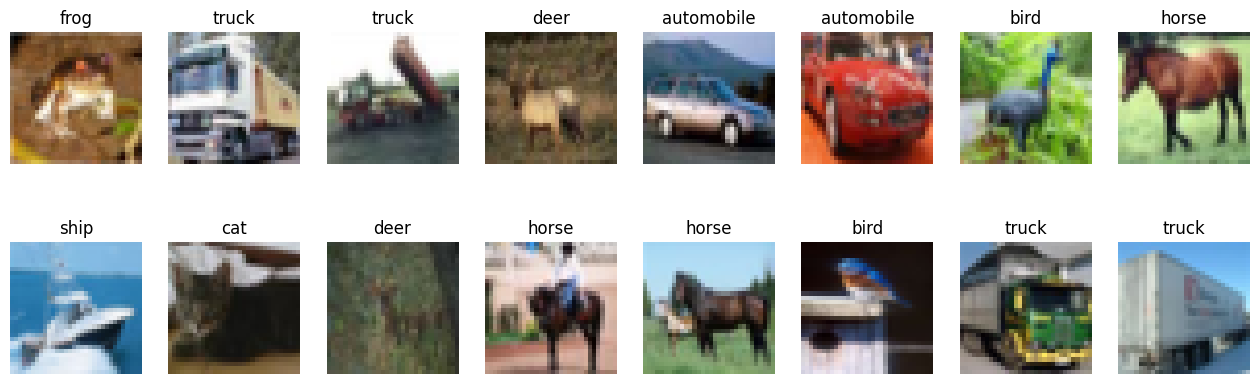

In [12]:
import mindspore
import matplotlib.pyplot as plt
import mindspore.dataset as ds

net = ShuffleNetV1(model_size="2.0x", n_class=10)
show_lst = []
param_dict = load_checkpoint("shufflenetv1-55_195.ckpt")
load_param_into_net(net, param_dict)
model = Model(net)
dataset_predict = ds.Cifar10Dataset(dataset_dir="./dataset/cifar-10-batches-bin", shuffle=False, usage="train")
dataset_show = ds.Cifar10Dataset(dataset_dir="./dataset/cifar-10-batches-bin", shuffle=False, usage="train")
dataset_show = dataset_show.batch(16)
show_images_lst = next(dataset_show.create_dict_iterator())["image"].asnumpy()
image_trans = [
    vision.RandomCrop((32, 32), (4, 4, 4, 4)),
    vision.RandomHorizontalFlip(prob=0.5),
    vision.Resize((224, 224)),
    vision.Rescale(1.0 / 255.0, 0.0),
    vision.Normalize([0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010]),
    vision.HWC2CHW()
        ]
dataset_predict = dataset_predict.map(image_trans, 'image')
dataset_predict = dataset_predict.batch(16)
class_dict = {0:"airplane", 1:"automobile", 2:"bird", 3:"cat", 4:"deer", 5:"dog", 6:"frog", 7:"horse", 8:"ship", 9:"truck"}
# 推理效果展示(上方为预测的结果，下方为推理效果图片)
plt.figure(figsize=(16, 5))
predict_data = next(dataset_predict.create_dict_iterator())
output = model.predict(ms.Tensor(predict_data['image']))
pred = np.argmax(output.asnumpy(), axis=1)
index = 0
for image in show_images_lst:
    plt.subplot(2, 8, index+1)
    plt.title('{}'.format(class_dict[pred[index]]))
    index += 1
    plt.imshow(image)
    plt.axis("off")
plt.show()
